In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as Data
import numpy as np
from sklearn.datasets import make_classification
from torch.autograd import Variable
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pdb

In [2]:
def cov(x, rowvar=False, bias=False, ddof=None, aweights=None):
    """Estimates covariance matrix like numpy.cov"""
    # ensure at least 2D
    if x.dim() == 1:
        x = x.view(-1, 1)

    # treat each column as a data point, each row as a variable
    if rowvar and x.shape[0] != 1:
        x = x.t()   #tensor.t()矩阵的转置

    if ddof is None:
        if bias == 0:
            ddof = 1
        else:
            ddof = 0

    w = aweights
    if w is not None:
        if not torch.is_tensor(w):
            w = torch.tensor(w, dtype=torch.float)
        w_sum = torch.sum(w)
        avg = torch.sum(x * (w/w_sum)[:,None], 0)
    else:
        avg = torch.mean(x, 0)  #torch.mean(x,0) 例子：[4,3]的矩阵对列求和取均值结果为[1,3]的矩阵

    # Determine the normalization
    if w is None:
        fact = x.shape[0] - ddof
    elif ddof == 0:
        fact = w_sum
    elif aweights is None:
        fact = w_sum - ddof
    else:
        fact = w_sum - ddof * torch.sum(w * w) / w_sum

    xm = x.sub(avg.expand_as(x))  # tensor下，a=b.sub(c)为a=b-c #x=x.expand_as(y)将x扩展为和y一样的维度  例子：如果x为大小为[1,3]的矩阵，y为[4,3]的矩阵，则拓展后x大小也为[4,3]，且同一列的数值都一样

    if w is None:
        X_T = xm.t()
    else:
        X_T = torch.mm(torch.diag(w), xm).t()

    c = torch.mm(X_T, xm)
    c = c / fact

    return c.squeeze() #tensor.squeeze()去掉维度中为1的维度 例子：大小为[1,2,1,3]会变为[2,3]

#协方差的求解步骤：(1)对x的每一列求均值   avg=torch.mean(x,0)
#               (2)对x的每一行减去均值   y=x.sub(avg.expand_as(x))
#               (3)cov=1/(m-1)*y.t()*y


def cov_x_y(x,y):
    #y = y.view(-1,1)  #tensor增加第二维的方法
    x_y = torch.cat((y,x),dim=1) #torch.cat((a,b),0)就是横着拼，得保证列维度相同，所以0就是表示改变的是第一个维度；同理，torch((a,b),1)就是竖着拼，改变的是第二个维度
    #a=torch.diag_embed(torch.rand(x_y.shape[1]))
    result=cov(x_y)
    #print(result.shape)
    #print(result)
    return result



def loss_function(x,y_true,y_pred):
    #pdb.set_trace()
    cov_true = cov_x_y(x,y_true)
    cov_estimate = cov_x_y(x,y_pred)
    
    #divergence between cov_true and cov_estimate
    diff_logm_1 = logm(cov_true)-logm(cov_estimate)
    inner_first_term_1 = torch.mm(cov_true, diff_logm_1)
    div_1 = torch.trace(inner_first_term_1-cov_true+cov_estimate)
    
    #divergence between cov_estimate and cov_true
    diff_logm_2 = logm(cov_estimate)-logm(cov_true)
    inner_first_term_2 = torch.mm(cov_estimate, diff_logm_2)
    div_2 = torch.trace(inner_first_term_2-cov_estimate+cov_true)
    
    div_total = div_1+div_2
    return div_total



def torch_von_Neumann_divergence(A,B):        
    #Divergence = np.trace(np.dot(A, logm(A)) - np.dot(A, logm(B)) - A + B)
    dev = A.device 
    
    A = A + torch.diag(torch.rand(A.size()[0],device=dev).uniform_(0.0000001, 0.00001))
    B = B + torch.diag(torch.rand(B.size()[0],device=dev).uniform_(0.0000001, 0.00001))


    Aeig_val, Aeig_vec = torch.symeig(A,True)    
    Beig_val, Beig_vec = torch.symeig(B,True)   
    
    Aeig_val, Beig_val = Aeig_val.abs(), Beig_val.abs()
    #A_val_temp, B_val_temp = Aeig_val.clone(), Beig_val.clone()

    z = torch.zeros(Aeig_val.shape, device=dev)
    o = torch.ones(Aeig_val.shape, device=dev)
    #Aeig_val = torch.where(Aeig_val<1e-7,z,Aeig_val)
    #Beig_val = torch.where(Beig_val<1e-7,z,Beig_val)
    A_val_temp, B_val_temp = Aeig_val.clone(), Beig_val.clone()
    A_val_temp = torch.where(A_val_temp<=0,o,A_val_temp) #torch.where合并o和A_Val_temp，即将A中小于等于0的元素用0代替
    B_val_temp = torch.where(B_val_temp<=0,o,B_val_temp)

    
    part1 = torch.sum(Aeig_val * torch.log(A_val_temp)   - Aeig_val + Beig_val) #矩阵的迹等于矩阵的特征值之和，对角矩阵的特征值等于对角线各元素
    lambda_log_theta = Aeig_val.unsqueeze(0).T *torch.log(B_val_temp.unsqueeze(0))
    part2 = (torch.matmul(Aeig_vec.T, Beig_vec)**2) * lambda_log_theta
    part2 = -part2.sum()

    Divergence = part1 + part2
    #print("time used for computing vm divergence {}".format(t2-t1))

    return Divergence

def loss_function_TRE(x,y_true,y_pred):
    #pdb.set_trace()
    cov_true = cov_x_y(x,y_true)
    cov_estimate = cov_x_y(x,y_pred)
    
    loss = torch_von_Neumann_divergence(cov_true,cov_estimate)+torch_von_Neumann_divergence(cov_estimate,cov_true)
    return loss


In [3]:
def train_generator(x_train,y_train):
    datasets = torch.utils.data.TensorDataset(x_train, y_train)
    train_iter = torch.utils.data.DataLoader(datasets, batch_size=20, shuffle=False)
    return train_iter

In [4]:
noise_rate_choice=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#noise_rate_choice=[1]

In [5]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        self.hidden_1= torch.nn.Linear(n_feature,64)   # hidden layer
        self.hidden_2 = torch.nn.Linear(64, 32)   # output layer
        #self.hidden_3 = torch.nn.Linear(32, 16)
        self.predict = torch.nn.Linear(32,n_output)
        #self.bat_1=torch.nn.BatchNorm1d(256)
        #self.bat_2=torch.nn.BatchNorm1d(128)
        #self.bat_3=torch.nn.BatchNorm1d(64)
        self.do=torch.nn.Dropout(0.5)

    def forward(self, x):
        x =torch.tanh(self.hidden_1(x))# activation function for hidden layer
        x =torch.tanh(self.hidden_2(x))
        #x =torch.tanh(self.hidden_3(x))
        #x=self.do(x)
        x = self.predict(x)             # linear output
        return x

In [6]:
def flip(Y, n_classes, flip_perc, circular_flip = True):
    Y = Y.copy()
    n, p, size = n_classes-1, flip_perc, Y.shape[0] 
    flip_vector = np.random.binomial(n, p, size)

    if circular_flip:
        Y[flip_vector==1] +=1
        Y[flip_vector==1] = Y[flip_vector==1]%n_classes
    else:
        new_Classes = np.random.randint(low=0, high= (n_classes-1), size=sum(flip_vector))
        new_Classes[Y[flip_vector==1]==new_Classes] =n_classes-1
        Y[flip_vector==1]=new_Classes
    return Y

In [8]:
def main(data,labels,number,epochs,noise):
  n_classes=2  

  loss_total_ours=[[0]*number for _ in range(len(noise))]
  loss_total_ce=[[0]*number for _ in range(len(noise))]
  mean_loss_ours=[[0] for _ in range(len(noise))]
  mean_loss_ce=[[0] for _ in range(len(noise))]

  for index in range(len(noise)):
    torch.manual_seed(4)  

    #generate training data and test data   
    X,Y = make_classification(n_samples=1200,
        n_features=3, n_informative=3,n_redundant=0, n_repeated=0, n_classes=n_classes, n_clusters_per_class=1,class_sep=1,
                                          flip_y=0,weights=[0.5,0.5], random_state=4)

    x_train,y_train = X[:1000,:] , Y[:1000] 
    x_test,y_test = X[1000:,:] , Y[1000:] 
    
    y_train = flip(y_train,n_classes,flip_perc=noise[index],circular_flip=True)
    
    #transfer numpy to torch
    x_test=torch.from_numpy(x_test).float()
    y_test=torch.from_numpy(y_test).float()

    x_train=torch.from_numpy(x_train).float()
    y_train=torch.from_numpy(y_train).float()

    #training loop for ours   
    net_ours = Net(n_feature=x_train.shape[1], n_output=n_classes)     # define the network
    print("ours noise level:{}".format(noise[index]))  # net architecture
    optimizer_ours= torch.optim.Adam(net_ours.parameters(), lr=0.0001)
    sm=torch.nn.Softmax(dim=1)

    for num in range(number):
      net_ours.train()
      for epoch in range(epochs):
        for inputs,labels in train_generator(x_train,y_train):
          prediction = net_ours(inputs)     # input x and predict based on x 
          train_pred = sm(prediction)
          label_one_hot=torch.nn.functional.one_hot(labels.to(torch.int64),num_classes=2).long()
          loss = loss_function_TRE(inputs,label_one_hot,train_pred)   # must be (1. nn output, 2. target)
          optimizer_ours.zero_grad()   # clear gradients for next train
          loss.backward()         # backpropagation, compute gradients
          optimizer_ours.step()        # apply gradients
        
      #evaluate the performance on test dataset
      net_ours.eval()
      output_ours=net_ours(x_test)
      _,test_pred_ours=output_ours.max(1)
      correct_ours=test_pred_ours.eq(y_test.long()).sum()
      loss_total_ours[index][num]=100. *correct_ours/x_test.shape[0]
    
    #training loop for ce
    net_ce = Net(n_feature=x_train.shape[1], n_output=n_classes)     # define the network
    print("ce noise level:{}".format(noise[index])) # net architecture
    optimizer_ce= torch.optim.Adam(net_ce.parameters(), lr=0.0001)
    loss_ce = torch.nn.CrossEntropyLoss()  # this is for regression mean squared loss
    
    for num in range(number):
      net_ce.train()
      for epoch in range(epochs):
        for inputs,labels in train_generator(x_train,y_train):
          prediction = net_ce(inputs)     # input x and predict based on x
          loss = loss_ce(prediction,labels.long())
          optimizer_ce.zero_grad()   # clear gradients for next train
          loss.backward()         # backpropagation, compute gradients
          optimizer_ce.step()        # apply gradients

      net_ce.eval()
      output_ce=net_ce(x_test)
      _,test_pred_ce=output_ce.max(1)
      correct_ce=test_pred_ce.eq(y_test.long()).sum()
      loss_total_ce[index][num]=100. *correct_ce/x_test.shape[0]
    
  #get the mean loss over number
  for row in range(len(noise)):
    mean_loss_ours[row]=torch.mean(torch.Tensor(loss_total_ours[row][:]))
  
  for row in range(len(noise)):
    mean_loss_ce[row]=torch.mean(torch.Tensor(loss_total_ce[row][:]))
    
  print(mean_loss_ours)
  print(mean_loss_ce)
  plt.plot(noise_rate_choice,mean_loss_ours,'r-',lw=2,label='ours')
  plt.plot(noise_rate_choice,mean_loss_ce,'b-',lw=2,label='ce')
  plt.xlabel('noise_level')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

ours noise level:0
ce noise level:0
ours noise level:0.1
ce noise level:0.1
ours noise level:0.2
ce noise level:0.2
ours noise level:0.3
ce noise level:0.3
ours noise level:0.4
ce noise level:0.4
ours noise level:0.5
ce noise level:0.5
ours noise level:0.6
ce noise level:0.6
ours noise level:0.7
ce noise level:0.7
ours noise level:0.8
ce noise level:0.8
ours noise level:0.9
ce noise level:0.9
ours noise level:1.0
ce noise level:1.0
[tensor(93.5000), tensor(81.), tensor(72.5000), tensor(68.5000), tensor(64.), tensor(54.), tensor(36.5000), tensor(29.5000), tensor(24.5000), tensor(22.5000), tensor(6.5000)]
[tensor(96.5000), tensor(94.), tensor(94.), tensor(94.5000), tensor(90.), tensor(76.5000), tensor(9.5000), tensor(8.5000), tensor(6.), tensor(5.5000), tensor(4.)]


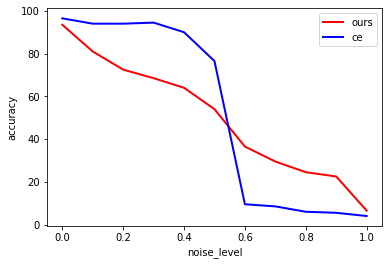

In [9]:
main(None,None,1,200,noise_rate_choice)